In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 16-6. 프로젝트 - Movielens 영화 SBR

이번에 우리는 `Movielens 1M Dataset`을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

우선 주요 라이브러리 버전을 확인해 보죠.

- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

<br>

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

In [2]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.5
2.8.0


In [3]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = Path('/content/drive/MyDrive/아이펠/풀잎스쿨/data/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


🧭`Time` 시리즈의 timestamp를 `datestamp` 정보로 변경한다.

In [5]:
date = []

for i in data['Time']:
    d=dt.datetime.fromtimestamp(i).isoformat()  # str로 반환됨
    d=dt.datetime.fromisoformat(d)  # str로 반환된 날짜를 다시 datetime으로 변환
    date.append(d) 
    
data['Time'] = date  # 변환된 datetime으로 교체
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


# Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, **session length**, **session time**, **cleaning** 등의 작업을 진행합니다.<br>
특히, 이 데이터셋에서는 Session이 아닌 **UserID** 단위로 데이터가 생성되어 있으므로, <u>이를 Session 단위로 어떻게 해석할지에 주의</u>합니다.

- **유저수(세션 수)**와 **아이템 수**를 확인한다.



In [6]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

- **유저수** : 6040명
- **아이템 수** : 3706개

**각 유저**가 <u>대략 몇 개의 클릭 데이터를 갖는지</u>도 살펴본다.



In [7]:
user_click = data.groupby('UserId').size()
user_click

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

- `user_click`란 같은 `userId`를 사용하는 사람이 클릭한 아이템의 수 (row의 갯수)
- 특정 사용자의 행동을 `userId` 기준으로 모아서 분류해낼 수 있다.

In [8]:
user_click.median(), user_click.mean()

(96.0, 165.5975165562914)

In [9]:
user_click.min(), user_click.max()

(20, 2314)

In [10]:
user_click.quantile(0.999)

1343.181000000005

- 각 유저의 **클릭 수**는 보통 **96~165번** 정도이다.
- 99.9% 세션은 길이가 **1343번**이하이다.
- 가장 많은 클릭 수는 **2314번**인데, 이상치이므로 이 유저의 데이터를 살펴 본다. 👇

In [11]:
# many_click은 인덱스 번호를 반환한다.
many_click = user_click[user_click==2314].index[0]
data[data['UserId']==many_click]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


- 같은 시간에 클릭한 아이템이 너무 많다. 이 데이터에서 아이템은 영화를 뜻하기 때문에, 같은 페이지에 있는 영화의 평점을 클릭으로 점수를 매기고 한 번에 제출한 것이 아닌가 하는 생각이 들었다.
- 그리고... 2년간의 데이터가 모여있어서 조금 난감한 상황..

- 세션 길이 기준 **하위 99.9%**까지의 분포 누적합을 시각화 해 본다.

In [12]:
click_count = user_click.groupby(user_click).size()
click_percent_cumsum = click_count.cumsum() / click_count.sum()
click_percent_cumsum_999 = click_percent_cumsum[click_percent_cumsum < 0.999]

click_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

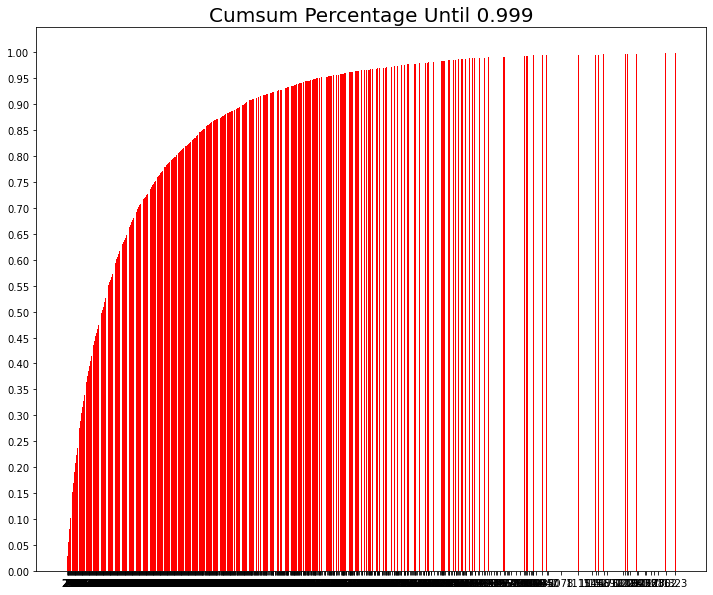

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=click_percent_cumsum_999.index,
        height=click_percent_cumsum_999, color='red')
plt.xticks(click_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

**Session Time**

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


- 약 3년간의 데이터가 있다.

In [15]:
year_ago = latest - dt.timedelta(365*2)     # 최종 날짜로부터 365일*2(2년) 이전 날짜를 구한다.  
data = data[data['Time'] > year_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time
2327,19,318,4,2001-07-08 01:43:18
2492,19,1234,5,2001-07-08 01:43:56
2503,20,1694,3,2001-12-29 23:37:51
2512,20,1468,3,2001-12-29 23:37:51
2513,20,3717,2,2001-12-29 23:37:51
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


**Data Cleansing**

앞선 예제에서는 클릭수가 적은 데이터를 제거했지만, 여기서는 평점(`rating`)이 4미만인 데이터를 제거하도록 한다.



In [16]:
data = data[data['Rating']>=4]
data

,UserId,ItemId,Rating,Time
2327,19,318,4,2001-07-08 01:43:18
2492,19,1234,5,2001-07-08 01:43:56
2517,20,2858,4,2001-12-29 23:37:51
2504,20,2641,4,2001-12-29 23:38:35
2520,20,3753,5,2001-12-29 23:38:36
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04


**Train/Valid/Test split**



In [17]:
data['Time'].max(), data['Time'].min() 

(Timestamp('2003-02-28 17:49:50'), Timestamp('2001-02-28 19:06:53'))

In [18]:
test_time = data['Time'].max() - dt.timedelta(60)
test_time

Timestamp('2002-12-30 17:49:50')

In [19]:
valid_time = test_time - dt.timedelta(120)
valid_time

Timestamp('2002-09-01 17:49:50')

In [20]:
train_df = data[data['Time'] <= valid_time]
train_df.tail()

,UserId,ItemId,Rating,Time
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000042,6040,1221,4,2001-08-20 13:44:15


In [21]:
test_df = data[data['Time'] > test_time]
test_df

,UserId,ItemId,Rating,Time
8704,59,2997,4,2003-01-07 18:02:48
8781,59,2369,4,2003-01-07 18:04:24
8797,59,3408,4,2003-01-07 18:04:52
8836,59,1959,4,2003-01-07 18:06:27
8834,59,2686,4,2003-01-07 18:06:48
...,...,...,...,...
984713,5950,3911,4,2003-02-27 18:03:46
984544,5950,3481,4,2003-02-27 18:04:50
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30


In [22]:
temp_df = data[data['Time'] <= test_time]
val_df = temp_df[temp_df['Time'] > valid_time]
val_df

,UserId,ItemId,Rating,Time
5200,36,2269,5,2002-12-22 08:05:50
5256,36,1701,4,2002-12-22 08:05:50
5364,36,3786,4,2002-12-22 08:08:41
5262,36,2369,4,2002-12-22 08:09:24
5280,36,3174,4,2002-12-22 08:11:25
...,...,...,...,...
964653,5812,543,4,2002-12-28 00:08:35
964540,5812,1722,4,2002-12-28 00:11:11
969105,5841,1965,4,2002-10-17 11:37:08
983995,5948,2804,5,2002-10-15 00:43:24


- data에 들어있는 값은 전처리를 통해 총 2년치의 데이터만 모았다.
- 이 데이터를 train/valid/test로 나눈다.
    - train : 18개월(30*18)
    - valid : 4개월(30*4)
    - test : 2개월(30*2)

In [26]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [27]:
stats_info(train_df, 'train')
stats_info(val_df, 'valid')
stats_info(test_df, 'test')

* train Set Stats Info
	 Events: 32497
	 Sessions: 925
	 Items: 2790
	 First Time : 2001-02-28 19:06:53
	 Last Time : 2002-09-01 04:20:59

* valid Set Stats Info
	 Events: 2925
	 Sessions: 251
	 Items: 1259
	 First Time : 2002-09-01 19:43:16
	 Last Time : 2002-12-30 16:54:04

* test Set Stats Info
	 Events: 1874
	 Sessions: 157
	 Items: 1035
	 First Time : 2002-12-30 18:21:02
	 Last Time : 2003-02-28 17:49:50



In [28]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train_df['ItemId'].unique())}
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train_df = indexing(train_df, id2idx)
val_df = indexing(val_df, id2idx)
test_df = indexing(test_df, id2idx)

In [29]:
data_path = Path('data')
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train_df.to_pickle(save_path / 'train.pkl')
val_df.to_pickle(save_path / 'valid.pkl')
test_df.to_pickle(save_path / 'test.pkl')

# Step 2. 미니 배치의 구성
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.<br>
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [31]:
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [32]:
tr_dataset = UserDataset(train_df)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
2327,19,318,4,2001-07-08 01:43:18,0
2492,19,1234,5,2001-07-08 01:43:56,1
2517,20,2858,4,2001-12-29 23:37:51,2
2504,20,2641,4,2001-12-29 23:38:35,3
2520,20,3753,5,2001-12-29 23:38:36,4
2507,20,3527,4,2001-12-29 23:39:41,5
2511,20,1527,5,2001-12-29 23:39:41,6
2523,20,1240,4,2001-12-29 23:39:41,7
2509,20,1371,4,2001-12-29 23:40:27,8
2671,22,1884,4,2001-05-29 15:10:55,9


In [33]:
tr_dataset.click_offsets

array([    0,     2,     9,    17,    26,    31,    85,   115,   187,
         207,   208,   234,   246,   247,   250,   255,   353,   432,
         434,   458,   468,   472,   484,   485,   496,   538,   544,
         548,   555,   644,   674,   737,   842,   849,  1002,  1004,
        1006,  1029,  1032,  1050,  1061,  1308,  1314,  1374,  1385,
        1412,  1431,  1441,  1659,  1661,  1671,  1761,  1825,  1830,
        1846,  1852,  1898,  1948,  1979,  2011,  2012,  2031,  2035,
        2041,  2072,  2078,  2092,  2109,  2130,  2159,  2162,  2287,
        2297,  2300,  2327,  2425,  2428,  2433,  2568,  2580,  2679,
        2782,  2957,  3037,  3039,  3057,  3058,  3068,  3088,  3092,
        3097,  3100,  3104,  3128,  3214,  3223,  3236,  3621,  3630,
        3633,  3692,  3715,  3744,  3765,  3768,  3789,  3794,  3847,
        3848,  3861,  3864,  3873,  3953,  3971,  3981,  3995,  3998,
        4038,  4044,  4049,  4052,  4053,  4059,  4127,  4128,  4136,
        4186,  4234,

In [34]:
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

**SessionDataLoader**

In [35]:
class UserDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [36]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
2327,19,318,4,2001-07-08 01:43:18,0
2492,19,1234,5,2001-07-08 01:43:56,1
2517,20,2858,4,2001-12-29 23:37:51,2
2504,20,2641,4,2001-12-29 23:38:35,3
2520,20,3753,5,2001-12-29 23:38:36,4
2507,20,3527,4,2001-12-29 23:39:41,5
2511,20,1527,5,2001-12-29 23:39:41,6
2523,20,1240,4,2001-12-29 23:39:41,7
2509,20,1371,4,2001-12-29 23:40:27,8
2671,22,1884,4,2001-05-29 15:10:55,9


In [37]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
2327,19,318,4,2001-07-08 01:43:18,0
2492,19,1234,5,2001-07-08 01:43:56,1
2517,20,2858,4,2001-12-29 23:37:51,2
2504,20,2641,4,2001-12-29 23:38:35,3
2520,20,3753,5,2001-12-29 23:38:36,4
2507,20,3527,4,2001-12-29 23:39:41,5
2511,20,1527,5,2001-12-29 23:39:41,6
2523,20,1240,4,2001-12-29 23:39:41,7
2509,20,1371,4,2001-12-29 23:40:27,8
2671,22,1884,4,2001-05-29 15:10:55,9


In [38]:
iter_ex = iter(tr_data_loader)

In [39]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  2  9 16]
Label Item Idx are :       [ 1  3 10 17]
Previous Masked Input Idx are []


# Step 3. 모델 구성
이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

**Evaluation Metric**

In [40]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [42]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [45]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [46]:
args = Args(train_df, val_df, test_df, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [47]:
model = create_model(args)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 1, 2790)]           0         
                                                                 
 GRU (GRU)                   [(32, 50),                426300    
                              (32, 50)]                          
                                                                 
 dropout (Dropout)           (32, 50)                  0         
                                                                 
 dense (Dense)               (32, 2790)                142290    
                                                                 
Total params: 568,590
Trainable params: 568,590
Non-trainable params: 0
_________________________________________________________________


# Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [54]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [55]:
train_model(model, args)

Evaluation:  76%|███████▌  | 63/83 [00:29<00:09,  2.16it/s]


	 - Recall@20 epoch 1: 0.056052
	 - MRR@20    epoch 1: 0.012238



Evaluation:  76%|███████▌  | 63/83 [00:28<00:09,  2.18it/s]


	 - Recall@20 epoch 2: 0.054563
	 - MRR@20    epoch 2: 0.012301



Evaluation:  76%|███████▌  | 63/83 [00:28<00:09,  2.20it/s]


	 - Recall@20 epoch 3: 0.056052
	 - MRR@20    epoch 3: 0.013227



Evaluation:  76%|███████▌  | 63/83 [00:28<00:09,  2.19it/s]


	 - Recall@20 epoch 4: 0.057044
	 - MRR@20    epoch 4: 0.013503



Evaluation:  76%|███████▌  | 63/83 [00:29<00:09,  2.13it/s]


	 - Recall@20 epoch 5: 0.068948
	 - MRR@20    epoch 5: 0.016712



Evaluation:  76%|███████▌  | 63/83 [00:29<00:09,  2.16it/s]


	 - Recall@20 epoch 6: 0.078373
	 - MRR@20    epoch 6: 0.018160



Evaluation:  76%|███████▌  | 63/83 [00:28<00:08,  2.23it/s]


	 - Recall@20 epoch 7: 0.081845
	 - MRR@20    epoch 7: 0.020819



Evaluation:  76%|███████▌  | 63/83 [00:28<00:09,  2.20it/s]


	 - Recall@20 epoch 8: 0.083333
	 - MRR@20    epoch 8: 0.022416



Evaluation:  76%|███████▌  | 63/83 [00:28<00:09,  2.21it/s]


	 - Recall@20 epoch 9: 0.089782
	 - MRR@20    epoch 9: 0.024614



Evaluation:  76%|███████▌  | 63/83 [00:28<00:08,  2.23it/s]

	 - Recall@20 epoch 10: 0.092262
	 - MRR@20    epoch 10: 0.026587



# Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

**1) 첫번째 시도**

- `batch_size` : 32
- ` epochs` : 10
- `k` : 20

In [58]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test_df)

Evaluation:  38%|███▊      | 20/53 [00:09<00:16,  2.04it/s]

	 - Recall@20: 0.068750
	 - MRR@20: 0.020329



**2) 두번째 시도**

- `batch_size` : 32 👉 16
- ` epochs` : 10
- `k` : 20

In [60]:
args = Args(train_df, val_df, test_df, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(16, 1, 2790)]           0         
                                                                 
 GRU (GRU)                   [(16, 50),                426300    
                              (16, 50)]                          
                                                                 
 dropout_1 (Dropout)         (16, 50)                  0         
                                                                 
 dense_1 (Dense)             (16, 2790)                142290    
                                                                 
Total params: 568,590
Trainable params: 568,590
Non-trainable params: 0
_________________________________________________________________


In [61]:
train_model(model, args)

Evaluation:  86%|████████▌ | 144/167 [00:36<00:05,  3.93it/s]


	 - Recall@20 epoch 1: 0.055556
	 - MRR@20    epoch 1: 0.011810



Evaluation:  86%|████████▌ | 144/167 [00:36<00:05,  3.90it/s]


	 - Recall@20 epoch 2: 0.062934
	 - MRR@20    epoch 2: 0.013836



Evaluation:  86%|████████▌ | 144/167 [00:36<00:05,  3.91it/s]


	 - Recall@20 epoch 3: 0.072049
	 - MRR@20    epoch 3: 0.014809



Evaluation:  86%|████████▌ | 144/167 [00:36<00:05,  3.94it/s]


	 - Recall@20 epoch 4: 0.068142
	 - MRR@20    epoch 4: 0.016514



Evaluation:  86%|████████▌ | 144/167 [00:36<00:05,  3.93it/s]


	 - Recall@20 epoch 5: 0.072049
	 - MRR@20    epoch 5: 0.018574



Evaluation:  86%|████████▌ | 144/167 [00:36<00:05,  3.92it/s]


	 - Recall@20 epoch 6: 0.078559
	 - MRR@20    epoch 6: 0.022973



Evaluation:  86%|████████▌ | 144/167 [00:36<00:05,  3.95it/s]


	 - Recall@20 epoch 7: 0.082899
	 - MRR@20    epoch 7: 0.025066



Evaluation:  86%|████████▌ | 144/167 [00:36<00:05,  3.99it/s]


	 - Recall@20 epoch 8: 0.085938
	 - MRR@20    epoch 8: 0.026655



Evaluation:  86%|████████▌ | 144/167 [00:35<00:05,  4.04it/s]


	 - Recall@20 epoch 9: 0.083767
	 - MRR@20    epoch 9: 0.026835



Evaluation:  86%|████████▌ | 144/167 [00:36<00:05,  3.97it/s]

	 - Recall@20 epoch 10: 0.085938
	 - MRR@20    epoch 10: 0.026945



In [62]:
test_model(model, args, test_df)

Evaluation:  58%|█████▊    | 62/107 [00:15<00:11,  3.98it/s]

	 - Recall@20: 0.097782
	 - MRR@20: 0.029524



**3) 세번째 시도**

- `batch_size` : 16 👉 8
- ` epochs` : 10
- `k` : 20

In [63]:
args = Args(train_df, val_df, test_df, batch_size=8, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(8, 1, 2790)]            0         
                                                                 
 GRU (GRU)                   [(8, 50),                 426300    
                              (8, 50)]                           
                                                                 
 dropout_2 (Dropout)         (8, 50)                   0         
                                                                 
 dense_2 (Dense)             (8, 2790)                 142290    
                                                                 
Total params: 568,590
Trainable params: 568,590
Non-trainable params: 0
_________________________________________________________________


In [64]:
train_model(model, args)

Evaluation:  97%|█████████▋| 323/334 [00:50<00:01,  6.39it/s]


	 - Recall@20 epoch 1: 0.054180
	 - MRR@20    epoch 1: 0.011340



Evaluation:  97%|█████████▋| 323/334 [00:48<00:01,  6.72it/s]


	 - Recall@20 epoch 2: 0.059211
	 - MRR@20    epoch 2: 0.012107



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.48it/s]


	 - Recall@20 epoch 3: 0.069272
	 - MRR@20    epoch 3: 0.015385



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.47it/s]


	 - Recall@20 epoch 4: 0.077012
	 - MRR@20    epoch 4: 0.018803



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.58it/s]


	 - Recall@20 epoch 5: 0.079334
	 - MRR@20    epoch 5: 0.021655



Evaluation:  97%|█████████▋| 323/334 [00:47<00:01,  6.75it/s]


	 - Recall@20 epoch 6: 0.083204
	 - MRR@20    epoch 6: 0.025124



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.51it/s]


	 - Recall@20 epoch 7: 0.086687
	 - MRR@20    epoch 7: 0.026509



Evaluation:  97%|█████████▋| 323/334 [00:48<00:01,  6.60it/s]


	 - Recall@20 epoch 8: 0.083591
	 - MRR@20    epoch 8: 0.026496



Evaluation:  97%|█████████▋| 323/334 [00:48<00:01,  6.60it/s]


	 - Recall@20 epoch 9: 0.084365
	 - MRR@20    epoch 9: 0.027159



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.56it/s]

	 - Recall@20 epoch 10: 0.086300
	 - MRR@20    epoch 10: 0.027055



In [65]:
test_model(model, args, test_df)

Evaluation:  74%|███████▍  | 158/214 [00:23<00:08,  6.73it/s]

	 - Recall@20: 0.097310
	 - MRR@20: 0.030906



- recall@20값은  **2) 두번째 시도**와 비슷하나, MRR@20은 소폭 상승했다.

**4) 네번째 시도**

배치사이즈를 아예 크게 잡아보면 어떨까 해서 크게해봄

- `batch_size` : 8 👉 128
- ` epochs` : 10
- `k` : 20

In [66]:
args = Args(train_df, val_df, test_df, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(128, 1, 2790)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               426300    
                              (128, 50)]                         
                                                                 
 dropout_3 (Dropout)         (128, 50)                 0         
                                                                 
 dense_3 (Dense)             (128, 2790)               142290    
                                                                 
Total params: 568,590
Trainable params: 568,590
Non-trainable params: 0
_________________________________________________________________


In [67]:
train_model(model, args)

Evaluation:  20%|██        | 4/20 [00:08<00:32,  2.02s/it]


	 - Recall@20 epoch 1: 0.070312
	 - MRR@20    epoch 1: 0.012443



Evaluation:  20%|██        | 4/20 [00:06<00:26,  1.66s/it]


	 - Recall@20 epoch 2: 0.076172
	 - MRR@20    epoch 2: 0.014294



Evaluation:  20%|██        | 4/20 [00:06<00:26,  1.67s/it]


	 - Recall@20 epoch 3: 0.080078
	 - MRR@20    epoch 3: 0.013915



Evaluation:  20%|██        | 4/20 [00:06<00:26,  1.65s/it]


	 - Recall@20 epoch 4: 0.083984
	 - MRR@20    epoch 4: 0.015377



Evaluation:  20%|██        | 4/20 [00:06<00:26,  1.66s/it]


	 - Recall@20 epoch 5: 0.070312
	 - MRR@20    epoch 5: 0.014510



Evaluation:  20%|██        | 4/20 [00:06<00:26,  1.67s/it]


	 - Recall@20 epoch 6: 0.066406
	 - MRR@20    epoch 6: 0.014272



Evaluation:  20%|██        | 4/20 [00:06<00:26,  1.67s/it]


	 - Recall@20 epoch 7: 0.078125
	 - MRR@20    epoch 7: 0.017340



Evaluation:  20%|██        | 4/20 [00:06<00:26,  1.66s/it]


	 - Recall@20 epoch 8: 0.056641
	 - MRR@20    epoch 8: 0.015584



Evaluation:  20%|██        | 4/20 [00:06<00:27,  1.69s/it]


	 - Recall@20 epoch 9: 0.054688
	 - MRR@20    epoch 9: 0.021421



Evaluation:  20%|██        | 4/20 [00:06<00:26,  1.67s/it]

	 - Recall@20 epoch 10: 0.060547
	 - MRR@20    epoch 10: 0.019881



In [68]:
test_model(model, args, test_df)

Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

	 - Recall@20: nan
	 - MRR@20: nan



- 에러가 났다..

**5) 다섯번째 시도**

recall@k와 MRR@k 값이 상승해야할것 같은데, 배치사이즈를 조절해 봐도 크게 개선되는 것이 없어서 epoch을 늘려봄<br>
세번째 시도가 지금까지 중 가장 높은 점수가 나왔기 때문에, 거기서 에폭을 50으로 늘림


- `batch_size` :  8
- ` epochs` : 10 👉 50
- `k` : 20

In [69]:
args = Args(train_df, val_df, test_df, batch_size=8, hsz=50, drop_rate=0.1, lr=0.001, epochs=50, k=20)
model = create_model(args)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(8, 1, 2790)]            0         
                                                                 
 GRU (GRU)                   [(8, 50),                 426300    
                              (8, 50)]                           
                                                                 
 dropout_4 (Dropout)         (8, 50)                   0         
                                                                 
 dense_4 (Dense)             (8, 2790)                 142290    
                                                                 
Total params: 568,590
Trainable params: 568,590
Non-trainable params: 0
_________________________________________________________________


In [70]:
train_model(model, args)

Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.52it/s]


	 - Recall@20 epoch 1: 0.056889
	 - MRR@20    epoch 1: 0.011798



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.51it/s]


	 - Recall@20 epoch 2: 0.060372
	 - MRR@20    epoch 2: 0.013082



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.49it/s]


	 - Recall@20 epoch 3: 0.065789
	 - MRR@20    epoch 3: 0.015512



Evaluation:  97%|█████████▋| 323/334 [00:50<00:01,  6.44it/s]


	 - Recall@20 epoch 4: 0.069659
	 - MRR@20    epoch 4: 0.017618



Evaluation:  97%|█████████▋| 323/334 [00:48<00:01,  6.64it/s]


	 - Recall@20 epoch 5: 0.078173
	 - MRR@20    epoch 5: 0.020669



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.58it/s]


	 - Recall@20 epoch 6: 0.081656
	 - MRR@20    epoch 6: 0.023934



Evaluation:  97%|█████████▋| 323/334 [00:50<00:01,  6.44it/s]


	 - Recall@20 epoch 7: 0.085139
	 - MRR@20    epoch 7: 0.024882



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.57it/s]


	 - Recall@20 epoch 8: 0.083204
	 - MRR@20    epoch 8: 0.025759



Evaluation:  97%|█████████▋| 323/334 [00:48<00:01,  6.63it/s]


	 - Recall@20 epoch 9: 0.083978
	 - MRR@20    epoch 9: 0.025350



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.53it/s]


	 - Recall@20 epoch 10: 0.086687
	 - MRR@20    epoch 10: 0.025667



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.51it/s]


	 - Recall@20 epoch 11: 0.085139
	 - MRR@20    epoch 11: 0.025259



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.56it/s]


	 - Recall@20 epoch 12: 0.080495
	 - MRR@20    epoch 12: 0.025862



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.53it/s]


	 - Recall@20 epoch 13: 0.080108
	 - MRR@20    epoch 13: 0.025254



Evaluation:  97%|█████████▋| 323/334 [00:47<00:01,  6.78it/s]


	 - Recall@20 epoch 14: 0.080108
	 - MRR@20    epoch 14: 0.024927



Evaluation:  97%|█████████▋| 323/334 [00:49<00:01,  6.56it/s]


	 - Recall@20 epoch 15: 0.080495
	 - MRR@20    epoch 15: 0.024570



Evaluation:  97%|█████████▋| 323/334 [00:48<00:01,  6.62it/s]


	 - Recall@20 epoch 16: 0.080108
	 - MRR@20    epoch 16: 0.024467



Evaluation:  97%|█████████▋| 323/334 [00:48<00:01,  6.61it/s]


	 - Recall@20 epoch 17: 0.076238
	 - MRR@20    epoch 17: 0.022672



Train:  47%|████▋     | 1854/3946 [00:27<00:30, 67.66it/s, accuracy=0.25, train_loss=4.08]


KeyboardInterrupt: ignored

- 오히려 값이 줄어드는 것같아서 황급히 중단...

In [71]:
test_model(model, args, test_df)

Evaluation:  74%|███████▍  | 158/214 [00:24<00:08,  6.33it/s]

	 - Recall@20: 0.075949
	 - MRR@20: 0.022176



- recall@20,  MRR@20둘 다 하락했다.

# 회고

## 공부한 내용

### 1. 추천 시스템의 평가 지표


**1-1) MRR (Mean Reciprocal Rank)**

- 사용자가 선호하는 아이템이 리스트 중 어디에 위치하는지에 중점을 둔 평가 기법이다.
- 추천된 리스트가 있고 사용자가 선호하는 아이템이 $k_{u}$라면, reciprocal rank는 $\frac{1}{k_{u}}$이다.
- 10개의 추천 리스트 중 사용자가 선호하는 아이템이 7번째에 있다면 reciprocal rank는 $\frac{1}{7}$이 되는 것이다.
- 그리고 MRR은 추천된 아이템 모두의 RR을 구해 평균값을 낸 것이다. MRR의 수식은 다음과 같다:
$$MRR(O, U)=\frac{1}{|U|} \sum_{u \in U} \frac{1}{k_{u}}$$

> **예시**<br>
유저 A와 B가 선호하는 (relevant) 영화는 ‘기생충’, ‘범죄와의 전쟁’, ‘아바타’, ‘테넷’입니다. 실제로 각 유저들이 선호하는 영화는 각각 다르겠지만 여기서는 편리성을 위해 둘 다 선호하는 영화가 같다고 가정하겠습니다. 우리의 추천모델은 유저 A에게 3개의 영화를 추천하였는데 ‘7광구’, ‘범죄와의 전쟁’, ‘기생충’를 추천하였습니다. 유저 B에게 역시 3개의 영화를 추천하는데 ‘아저씨’, ‘공동경비구역 JSA’, ‘아바타’를 추천하였습니다.

<br>

**1-2) Precision@k**

- precision@k는 k개의 추천 중 실제로 사용자가 선호하는 (relevant) 아이템이 얼마나 존재하는지를 측정하는 지표이다. 
- 분모는 추천한 아이템의 개수, 분자는 relevant한 아이템의 개수
- 따라서 유저 A의 경우 precision@3 = 2/3, 유저 B의 경우 1/3 의 값을 갖게 된다.
- 여기서 Precision의 의미는 “사용자에게 useful한 item을 얼마나 잘 추천해주었는가”이다.

<br>

**1-3) Recall@k**

<br>

- recall@k는 전체 relevant한 아이템 중 추천된 아이템이 속한 비율이다.
- 분모는 전체 relevant한 아이템의 개수, 분자는 k개의 추천 중 relevant한 아이템의 개수이다.
- 따라서 유저 A의 경우 recall@3 = 2/4, 유저 B의 경우 1/4의 값을 갖게 된다.
- 왜냐하면 유저 A에게 추천한 아이템 3개 중 실제 relevant한 아이템은 2개, 유저 B의 경우 1개이기 때문
- 여기서 recall의 의미는 “useful stuff에 대한 추천을 최대한 놓치지 않는 것”이다.

<br>

**1-4) Hit@k**

<br>

- hit@k를 사용하는 경우도 있다.
- k개의 추천 중에 relevant한 것이 있으면 1 아니면 0을 나타낸다.
- 따라서 유저 A의 경우 1, 유저 B의 경우도 1

<br>

- 해당 metric들을 모든 user로부터 구한 뒤 user 수로 평균을 내서 test set에 대한 metric을 구할 수 있다.
- 위 예시에서는 
    - precsion@3은 (2/3 + 1/3) / 2 = 1/2
    - recall@3은 (2/4 + 1/4) / 2 = 3/8
    - hit@3은 (1 + 1) / 2 = 1 
이다.

<br><br>

- 참고 블로그 : https://sungkee-book.tistory.com/11

## 루브릭 평가 지표를 맞추기 위해 시도한 것들

|평가문항|상세기준|
|:------|:---|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|

- 데이터셋을 유저별 클릭수가 아닌, **평점 4이상**으로 설정했다.

|개선시도|파라미터|Recall@20|MRR@20|
|:---:|:---|:---:|:---:|
|1)|`batch_size` : 32<br><br>` epochs` : 10<br><br>`k` : 20| 0.068750 | 0.020329|
|2)|`batch_size` : 16<br><br>` epochs` : 10<br><br>`k` : 20|0.097782|0.029524|
|3)|`batch_size` : 8<br><br>` epochs` : 10<br><br>`k` : 20|0.097310|0.030906|
|4)|`batch_size` : 1288<br><br>` epochs` : 10<br><br>`k` : 20|nan|nan|
|5)|`batch_size` : 8<br><br>` epochs` : 50<br><br>`k` : 20|0.075949|0.022176|

- Recall@20과 MRR@20 점수를 높이기 위해 하이퍼파라미터 조절을 여러차례 해 보았다.
- 배치사이즈가 적은 것이 가장 좋았지만, 에폭수를 늘려보니 과적합으로 오히려 10에폭 일 때 보다 낮은 성능지표가 나옴 ( **다섯번 째**)

<Br>

- 지난 익플14에서는 추천시스템이 재미있었는데... 이번 익플은 좀 이해도 안되고 어떻게 진행했는지 모르겠다.
- 심지어 다 하고 나니, 지난번 추천 영화는 평점을 기준으로 한 것이고 이번 익플에서는 유저별 클릭 수를 기준으로 해야만 했던 것인가... 하는 생각이 뒤늦게 들었다. (평가 지표를 찾아보니 그런것같았다...)